# Research Data Useful for Time Management - Google 

In [1]:
# Load standard python libraies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import scipy.stats as stats
%matplotlib inline

import itertools

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import json
import math

### Load Google Maps Data

In [3]:
# Function to extract maps data
def js_r(filename):
   with open(filename) as f_in:
       return(json.load(f_in))

In [309]:
location_history = js_r('maps_location_history.json')
locations = pd.DataFrame(location_history['locations'])
locations.tail()

,accuracy,activity,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy
618993,15,"[{'timestampMs': '1569629020489', 'activity': ...",24.0,NaN,-275943325,-485174486,1569629305108,NaN,2.0
618994,15,"[{'timestampMs': '1569629810766', 'activity': ...",24.0,NaN,-275943325,-485174486,1569630205181,NaN,2.0
618995,15,"[{'timestampMs': '1569630454073', 'activity': ...",24.0,NaN,-275943301,-485174428,1569630539687,NaN,2.0
618996,15,"[{'timestampMs': '1569631886667', 'activity': ...",24.0,NaN,-275943301,-485174428,1569631451294,NaN,2.0
618997,15,NaN,24.0,NaN,-275943301,-485174428,1569632395683,NaN,2.0


In [310]:
#locations.info()

### Prepare Activity Data

In [286]:
# Extract activity data
def get_type(row):
    df2 = pd.DataFrame(row)
    return df2.loc[df2['confidence'].idxmax()].type

def extract_activity(row):
    df = pd.DataFrame(row)
    act_time = df.timestampMs
    act_type = pd.DataFrame(df.activity.apply(lambda x : get_type(x)))
    return pd.concat([act_time, act_type], axis=1)

def combine_dfs(df, row):
    if type(row)==float:
        return df
    else:
        extract = extract_activity(row)
        return pd.concat([df,extract], ignore_index=True)


In [298]:
# Test with 10,000 records
tail = locations.activity.tail(10000)

In [299]:
# initialize empty df
df_act = pd.DataFrame(columns=['timestampMs','activity'])

# runs 10,000 records per minute - used most likely activity per stamp
for i in range(1,len(tail)):
    df_act = combine_dfs(df_act,tail.iloc[i])

In [302]:
# Clean df
df_act['date'] = pd.to_datetime(df_act['timestampMs'],unit='ms')
df_act.drop(['timestampMs'],axis=1,inplace=True)
df_act.activity = df_act.activity.astype('category')
df_act['week'] = df_act.date.dt.week
df_act['month'] = df_act.date.dt.month
df_act['weekday'] = df_act.date.dt.weekday
df_act['day'] = df_act.date.dt.day
df_act['year'] = df_act.date.dt.year
df_act.weekday = df_act.weekday.astype(str)
df_act.weekday = df_act.weekday.replace({'0':'Monday', '1':'Tuesday', '2':'Wednesday', '3':'Thursday', '4':'Friday', '5':'Saturday', '6':'Sunday'})
df_act.weekday = df_act.weekday.astype('category')

In [411]:
df_activity = df_act.copy()

### Explore Activity Data

In [412]:
df_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23724 entries, 0 to 23723
Data columns (total 7 columns):
activity    23724 non-null category
date        23724 non-null datetime64[ns]
week        23724 non-null int64
month       23724 non-null int64
weekday     23724 non-null category
day         23724 non-null int64
year        23724 non-null int64
dtypes: category(2), datetime64[ns](1), int64(4)
memory usage: 973.9 KB


In [416]:
df_activity.head()

,activity,date,week,month,weekday,day,year
0,TILTING,2019-07-27 18:48:08.547,30,7,Saturday,27,2019
1,STILL,2019-07-27 18:48:38.051,30,7,Saturday,27,2019
2,TILTING,2019-07-27 18:49:04.508,30,7,Saturday,27,2019
3,STILL,2019-07-27 18:49:17.503,30,7,Saturday,27,2019
4,UNKNOWN,2019-07-27 18:49:59.898,30,7,Saturday,27,2019


In [419]:
df_activity = df_activity.drop(df_activity[df_activity.activity.isin(['ON_BICYCLE','EXITING_VEHICLE','UNKNOWN','TILTING'])].index)

In [420]:
activity_by_dow = df_activity.groupby('weekday').activity.value_counts()

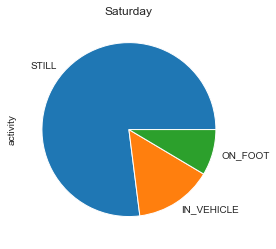

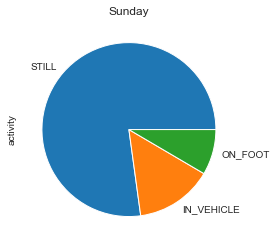

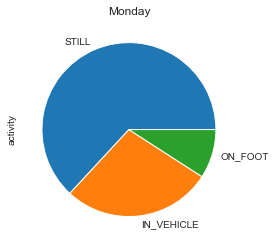

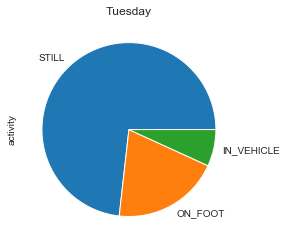

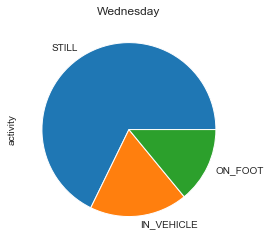

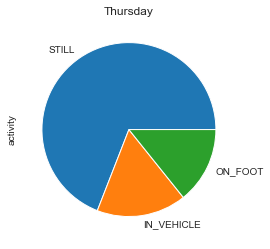

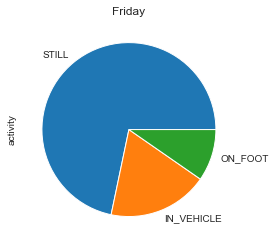

In [421]:
dow = list(df_activity.weekday.unique())

for day in dow:
    
    ax = plt.subplot()
    activity_by_dow[day].plot(kind='pie')

    plt.title(day)
    plt.show()   

### Prepare Time-Location Data

In [312]:
timespace = locations[['latitudeE7','longitudeE7','timestampMs']]

In [313]:
timespace['date'] = pd.to_datetime(timespace['timestampMs'],unit='ms')
timespace.rename(columns={"longitudeE7":"long","latitudeE7":"lat"}, inplace=True)
timespace = timespace[['date','lat','long']]
timespace.lat = timespace.lat.apply(lambda x : x/1e7)
timespace.long = timespace.long.apply(lambda x : x/1e7)

In [418]:
timespace.head()

,date,lat,long
0,2014-05-12 19:39:24.021,53.532108,-113.961557
1,2014-08-23 01:25:35.137,-27.612048,-48.582699
2,2014-12-27 22:39:46.266,53.531931,-113.961383
3,2015-04-22 01:59:27.950,-27.612014,-48.583035
4,2015-04-22 02:15:21.160,-27.575069,-48.531032


In [434]:
timespace.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618998 entries, 0 to 618997
Data columns (total 3 columns):
date    618998 non-null datetime64[ns]
lat     618998 non-null float64
long    618998 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 14.2 MB
